In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [ ]:
!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

Dataset URL: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri
License(s): MIT
brain-tumor-classification-mri.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
with zipfile.ZipFile('/content/brain-tumor-classification-mri.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [ ]:
import os
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
import io
from PIL import Image
from warnings import filterwarnings
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D,GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
from tqdm import tqdm
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [ ]:
X_train = []
y_train = []
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

image_size=224
for i in labels:
    folderPath = os.path.join('/content/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
for i in labels:
    folderPath = os.path.join('/content/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 178.20it/s]


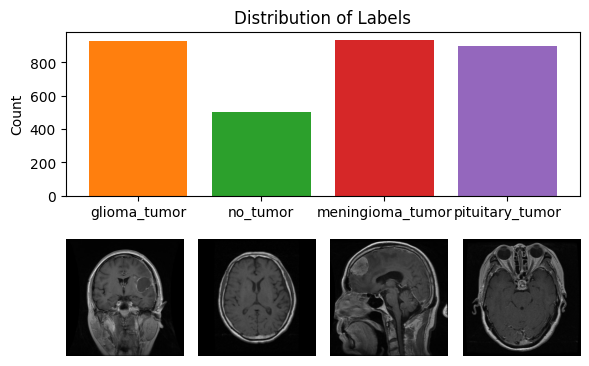

In [ ]:
label_counts = {label: np.sum(y_train == label) for label in labels}

# Plot the bar plot and sample images in one chart
plt.figure(figsize=(6,4))

colors = ["C1", "C2", "C3", "C4"]
plt.subplot(2, 1, 1)
bars = plt.bar(label_counts.keys(), label_counts.values(), color=colors)
# plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')

# Plot sample images from each label
k = 0
for i in labels:
  j = 0
  while True:
    if y_train[j] == i:
      plt.subplot(2, 4, k + 5)
      plt.imshow(X_train[j])
      plt.axis('off')
      k += 1
      break
    j += 1

plt.tight_layout()
plt.show()

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest')

datagen.fit(X_train)

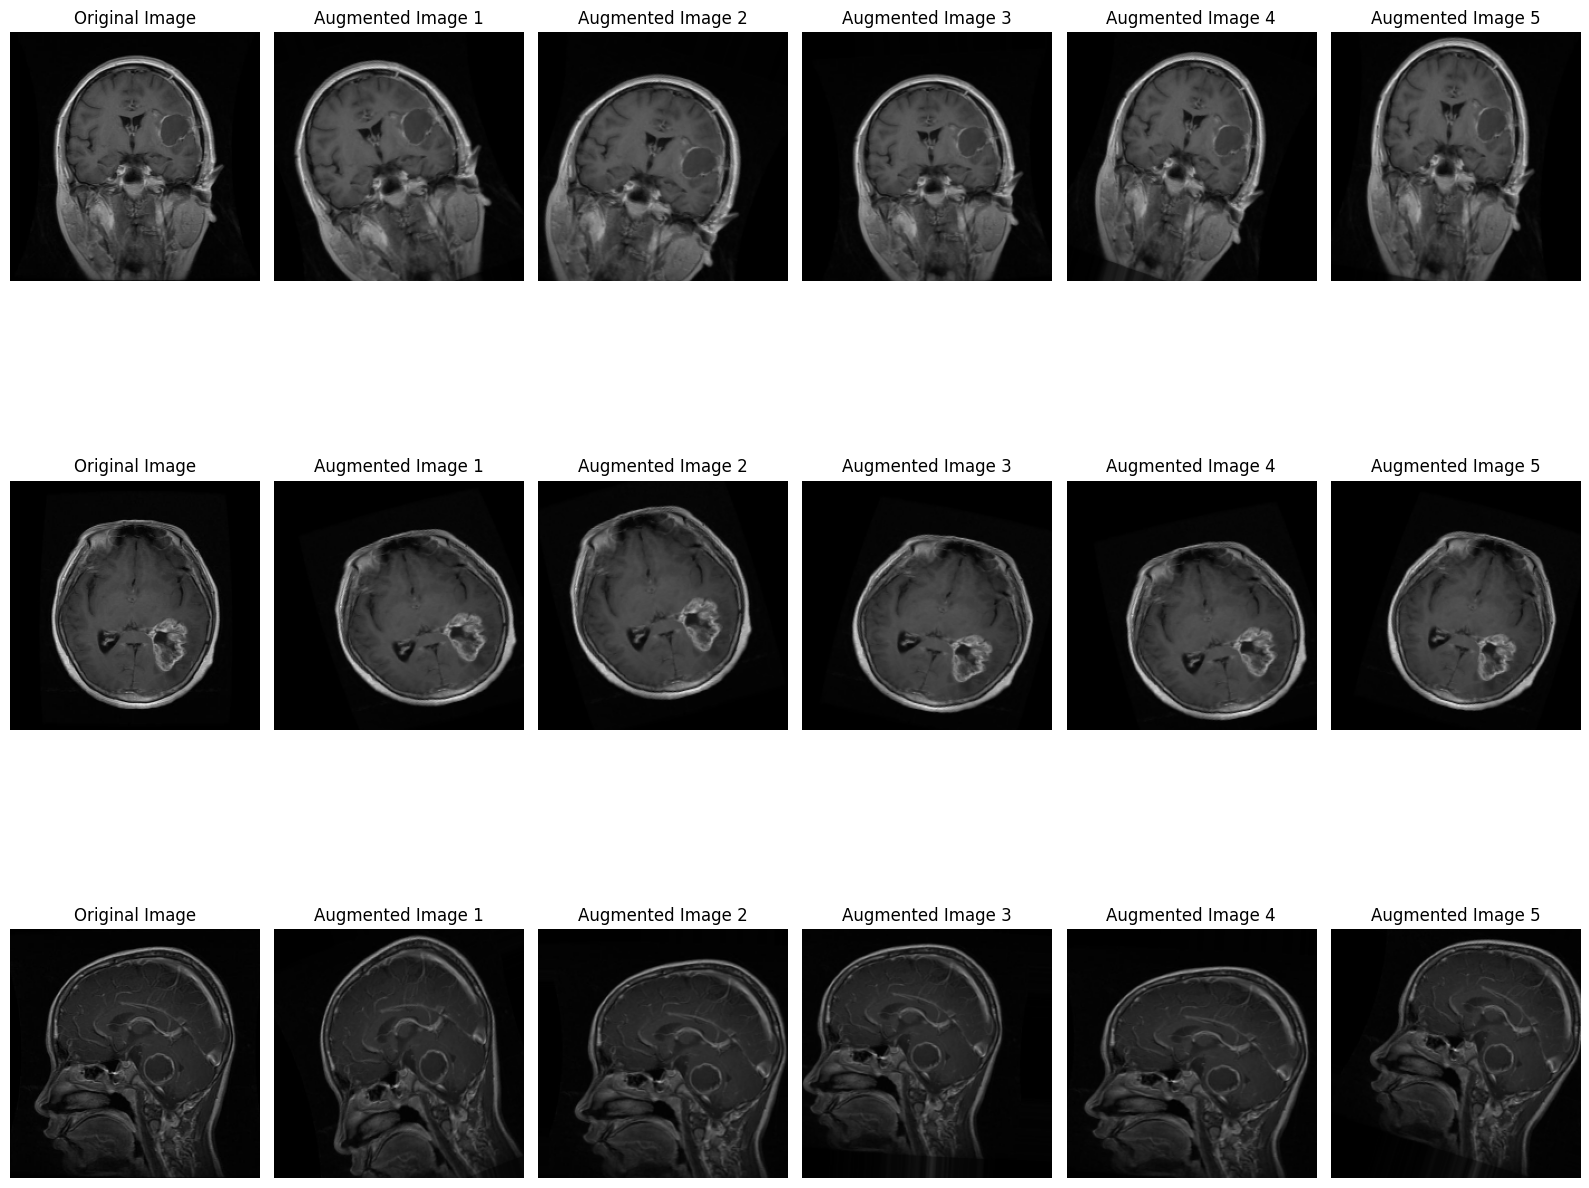

In [ ]:
def visualize_augmented_images(image_generator, num_samples, num_augmented_images):
  fig, axes = plt.subplots(num_samples, num_augmented_images + 1, figsize=( 16, num_samples * 5))

  for i in range(num_samples):
    # Get original image
    sample = X_train[i]
    axes[i, 0].imshow(sample)
    axes[i, 0].set_title('Original Image')
    axes[i, 0].axis('off')

    # augmented images
    for j in range(num_augmented_images):
      augmented_image = image_generator.random_transform(sample)
      axes[i, j + 1].imshow(augmented_image)
      axes[i, j + 1].set_title(f'Augmented Image {j + 1}')
      axes[i, j + 1].axis('off')

  plt.tight_layout()
  plt.show()

#Visualize augmented images
visualize_augmented_images(datagen, num_samples=3, num_augmented_images=5)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
#normalization
X_train = X_train / 255
X_test = X_test / 255
X_valid = X_valid / 255

print(f"Maximum and Minimum after normalization: {X_train.max()} - {X_train.min()}")

Maximum and Minimum after normalization: 1.0 - 0.0


In [ ]:
resnet = tf.keras.applications.ResNet101(weights='imagenet', include_top=False,
                                         input_shape=(image_size, image_size, 3))

# Build the custom model on top of the ResNet101 base

model = resnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=resnet.input, outputs = model)



In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
tensorboard = TensorBoard(log_dir='logs')

# Modelcheckpoint callback to save the best model
checkpoint = ModelCheckpoint("efficientnetB0.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

# ReduceLROnPlateau callback to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2,
                              min_delta=0.0001, verbose=1)

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =15, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/15
75/75 [==============================] - ETA: 0s - loss: 0.9620 - accuracy: 0.6779
Epoch 1: val_accuracy improved from -inf to 0.29057, saving model to efficientnetB0.keras
75/75 [==============================] - 126s 680ms/step - loss: 0.9620 - accuracy: 0.6779 - val_loss: 1508.0706 - val_accuracy: 0.2906 - lr: 0.0010
Epoch 2/15
75/75 [==============================] - ETA: 0s - loss: 0.5753 - accuracy: 0.7851
Epoch 2: val_accuracy did not improve from 0.29057
75/75 [==============================] - 42s 566ms/step - loss: 0.5753 - accuracy: 0.7851 - val_loss: 21.5619 - val_accuracy: 0.2906 - lr: 0.0010
Epoch 3/15
75/75 [==============================] - ETA: 0s - loss: 0.3507 - accuracy: 0.8860
Epoch 3: val_accuracy improved from 0.29057 to 0.36226, saving model to efficientnetB0.keras
75/75 [==============================] - 49s 659ms/step - loss: 0.3507 - accuracy: 0.8860 - val_loss: 2.0298 - val_accuracy: 0.3623 - lr: 0.0010
Epoch 4/15
75/75 [==========================

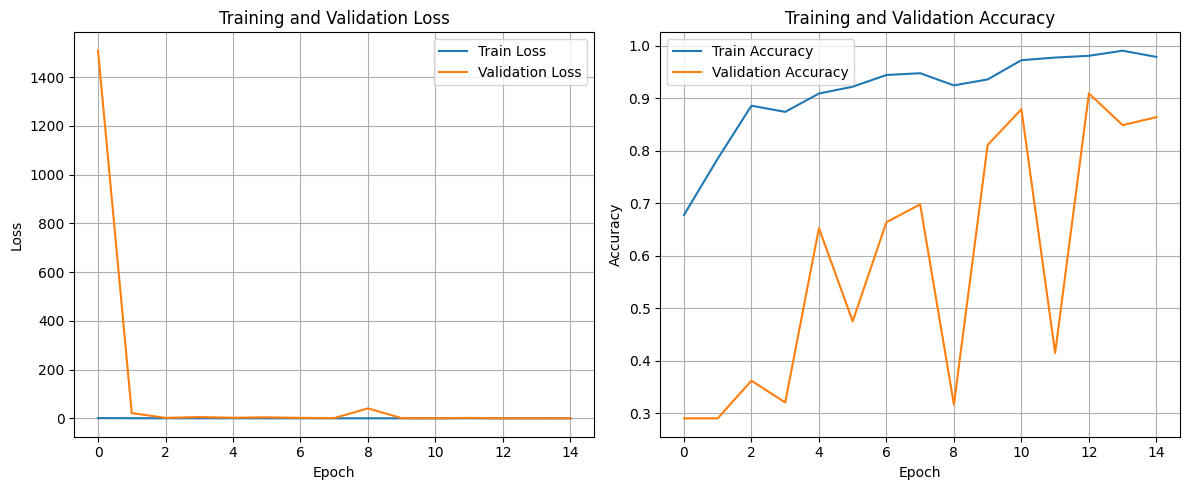

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()


In [ ]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1)


11/11 [==============================] - 5s 265ms/step


In [ ]:
print(classification_report(y_true_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89       117
           1       0.66      0.91      0.77        45
           2       0.91      0.69      0.78        87
           3       0.96      0.88      0.92        78

    accuracy                           0.85       327
   macro avg       0.85      0.85      0.84       327
weighted avg       0.87      0.85      0.85       327



In [ ]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]
predictions = model.predict(random_img.reshape(1, 224, 224, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()

NameError: name 'np' is not defined